# Tutorial 04 - Loading and printing surface positions in world camera coordinate space

In this tutorial we will look at how to load surface position data that was exported from Pupil Player in order to get positions of surfaces in pixels. We will follow these steps:

1. Load the data using `Pandas`
2. Transform and map surface vertices into world camera pixel coordinates
3. Visualize the surfaces in world camera pixel space

Raw Recording Data: To execute this notebook, download the [sample recording](https://drive.google.com/file/d/1vzjZkjoi8kESw8lBnsa_k_8hXPf3fMMC/view?usp=sharing). Unzip and move it into the `recordings` directory for this repository.

## 1 - Loading Exported Surface Data

Now lets see how to load the exported surface position data for a single surface.
The file will be named with the pattern `surf_positions_<your-surface-name>.csv`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/sample_recording_v2.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/sample_recording_v2.zip
   creating: sample_recording_v2/
  inflating: sample_recording_v2/eye1_timestamps.npy  
  inflating: sample_recording_v2/notify_timestamps.npy  
  inflating: sample_recording_v2/gaze_timestamps.npy  
  inflating: sample_recording_v2/pupil.pldata  
  inflating: sample_recording_v2/world.intrinsics  
  inflating: sample_recording_v2/eye0_lookup.npy  
  inflating: sample_recording_v2/world_timestamps.npy  
  inflating: sample_recording_v2/eye0.mp4  
  inflating: sample_recording_v2/eye0_timestamps.npy  
  inflating: sample_recording_v2/world.mp4  
  inflating: sample_recording_v2/square_marker_cache  
  inflating: sample_recording_v2/notify.pldata  
  inflating: sample_recording_v2/surface_definitions_v01  
  inflating: sample_recording_v2/eye1.mp4  
  inflating: sample_recording_v2/pupil_timestamps.npy  
  inflating: sample_recording_v2/surface_definitions  
  inflating: sample_recording_v2/eye1_lookup.np

In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

# the matrix in the csv file does not have commas to separate values
# we need to do a bit of formatting with our parse function
# so that we will be able to read the matrix in python as numeric and not strings
def parse(filedata):
    output = []
    for line in filedata.split('\n'):
        line = line.strip().rstrip(']').lstrip('[')
        if not line:
            continue
        line = line.split()
        row = []
        for cell in line:
            cell = cell.strip()
            if not cell.strip():
                continue
            row.append(float(cell))
        output.append(row)
    return output

# recording_location = Path(".") / "recordings" / "sample_recording_v2"
# surface_positions_export = recording_location / "exports" / "000" / "surfaces" / "surf_positions_Cover.csv"
surface_positions_export = "/content/sample_recording_v2/exports/000/surfaces/surf_positions_Cover.csv"

surface_df = pd.read_csv(
    surface_positions_export,
    converters={
        "img_to_surf_trans": parse,
        "surf_to_img_trans": parse,
        "dist_img_to_surf_trans": parse,
        "surf_to_dist_img_trans": parse,
    },
)

print("Columns present in exported surface positions data file:")
list(surface_df.columns)

Columns present in exported surface positions data file:


['world_index',
 'world_timestamp',
 'img_to_surf_trans',
 'surf_to_img_trans',
 'num_detected_markers',
 'dist_img_to_surf_trans',
 'surf_to_dist_img_trans']

### Individual Datums

As we can see the data frame contains only a few columns. Let's review what each column is used for:

- `world_index` - The frame number of the world camera to which this sample is correlated.
- `world_timestamp` - The world camera timestamp at which the sample was recorded.
- `surf_to_img_trans` - 3x3 transformation matrix from reference surface coordinate space to camera coordinate space.
- `img_to_surf_trans` - 3x3 transformation matrix from camera coordinate space to reference surface coordinate space.
- `num_detected_markers` - number of markers that were detected for this datum.
- `surf_to_dist_img_trans` - 3x3 transformation matrix from reference surface coordinate space to distored camera image coordinate space.
- `dist_img_to_surf_trans` - 3x3 transformation matrix from distorted camera image coordinate space to reference surface coordinate space.

Let's take a look at a few values!


In [3]:
pd.options.display.float_format = '{:.3f}'.format

print("Sample surface positions on magazine cover")
surface_df.head(5)

Sample surface positions on magazine cover


,world_index,world_timestamp,img_to_surf_trans,surf_to_img_trans,num_detected_markers,dist_img_to_surf_trans,surf_to_dist_img_trans
0,115,329357.774,"[[0.00263960561, 0.000258024554, -1.4871294], ...","[[432.782785, 229.303603, 493.747392], [50.434...",2,"[[0.0030285129, 0.000194267257, -1.67875971], ...","[[365.64173, 145.95268, 510.581853], [32.64804..."
1,116,329357.808,"[[0.00261582559, 0.00019850843, -1.4012222], [...","[[435.723386, 211.060864, 481.434227], [42.407...",2,"[[0.00302976495, 0.000112532247, -1.59118345],...","[[359.978569, 128.609103, 499.827144], [21.689..."
2,117,329357.841,"[[0.0026187739, 0.000173288569, -1.35359237], ...","[[432.540891, 199.779003, 469.328973], [33.122...",2,"[[0.00306237719, 7.00499775e-05, -1.54690935],...","[[349.71635, 117.193549, 489.468255], [10.1143..."
3,118,329357.875,"[[0.00259789821, 0.000159650922, -1.30252423],...","[[433.895434, 199.676274, 456.884857], [26.767...",2,"[[0.00307119832, 4.02705214e-05, -1.49906748],...","[[343.34524, 114.501667, 479.083638], [1.25796..."
4,119,329357.908,"[[0.00260710667, 0.000144657347, -1.26679811],...","[[430.646791, 190.551657, 445.437284], [21.533...",2,"[[0.00311598505, 8.21239822e-06, -1.46911632],...","[[333.917356, 104.273391, 469.655811], [-6.215..."


## 2 - Transform and map surface vertices into world camera pixel coordinates

Use each transformation matrix to get the "distorted" corner coordinates of the surface. The surface corners are always `((0,0), (0,1), (1,1), (1,0))`. For the perspective transform, we convert the corners into homogenous coordinates, before multiplying them with the transform matrix. Afterward, we project the homogenous result back into two-dimensional points. The result is the position of the corner in the distorted space of the world camera.

In [4]:
def transform_surface_corners(pos, matrix):
    num_pos = pos.shape[0]
    homogenous_component = np.ones((num_pos, 1))
    pos_homogenous = np.hstack([pos, homogenous_component])

    # actual transform
    result_homogenous = pos_homogenous @ matrix.T
    result_homogenous /= result_homogenous[:, -1:]  # normalise
    new_pos = result_homogenous[:, :-1]  # projection
    return new_pos

matrices = surface_df['surf_to_dist_img_trans']
corners = [[0.,0.],[0.,1.],[1.,1.],[1.,0.]]

# use the transformation matrix to map the corners of the surface to pixel space
# 1. transform corners with perspective transformation using the matrix
# 2. denormalize the coordinates to that we mapped to the scale of the screen
surface_screen_corners = []
for matrix in matrices:
    denormalized_corner_positions = transform_surface_corners(np.array(corners), np.asarray(matrix))
    surface_screen_corners.append(denormalized_corner_positions)

# add corners of the surface in screen coordinates back to the pandas dataframe for convenience
surface_df = surface_df.assign(surface_position_screen=pd.Series(surface_screen_corners))

# confirm that the corners of the surface mapped to pixel space are in the data frame
surface_df['surface_position_screen'].head(5)

,surface_position_screen
0,"[[510.581853, 681.823516], [531.6896987793156,..."
1,"[[499.827144, 682.690438], [511.99428775729837..."
2,"[[489.468255, 684.838702], [496.9189132666165,..."
3,"[[479.083638, 688.012312], [483.3437666569325,..."
4,"[[469.655811, 691.130298], [470.51052512471944..."


## 3. Visualize the surfaces in world camera pixel space

We will simply plot the instances of this surface - `Cover` - within this recording using matplot lib. The plot size is equal to the world camera frame `1280 pixels x 720 pixels`.

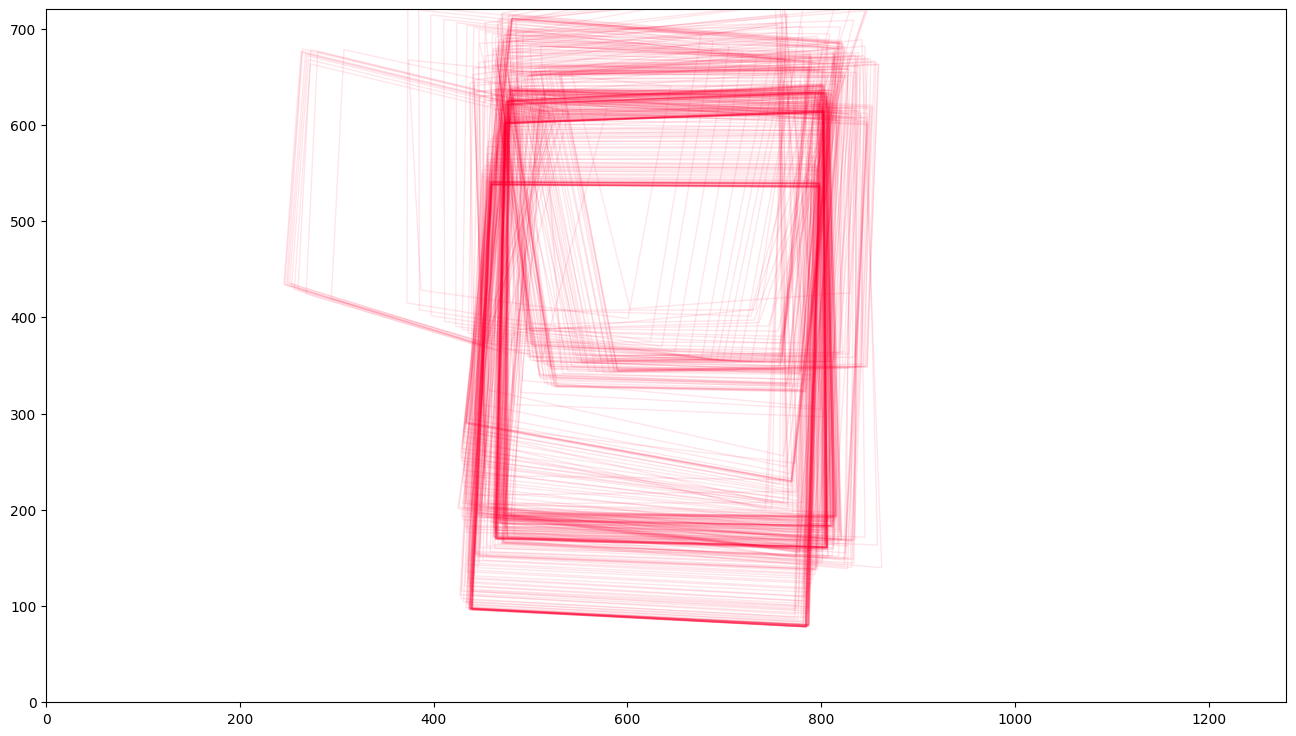

In [5]:
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

plt.figure(figsize = (16, 9))

axes = plt.gca()
axes.set_xlim([0., 1280.])
axes.set_ylim([0., 720.])

polygons = PolyCollection(
    surface_df['surface_position_screen'],
    edgecolors=((1.0, 0.0, 0.2, 0.1),),
    facecolors=((0,0,0,0),),
)
axes.add_collection(polygons)
plt.show()